<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/pollardstown_svm_4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip
!unzip -q "/content/drive/MyDrive/Pollardstown.zip" -d "/content/dataset"


In [3]:

!ls /content/dataset/Pollardstown/

'habitat info.docx'	     Pollardstown_clappied.shx
 Pollardstown_clappied.cpg   pollardstown_ortho.tif
 Pollardstown_clappied.dbf   Pollardstown_Summer_NDVI.tif
 Pollardstown_clappied.prj   Pollardstown_Winter_NDVI.tif
 Pollardstown_clappied.qmd   Pollardstown_Winter_RGB.tif
 Pollardstown_clappied.shp


In [4]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
RGB_PATH = '/content/dataset/Pollardstown/pollardstown_ortho.tif'
NDVI_PATH = '/content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif'
SHP_PATH = '/content/dataset/Pollardstown/Pollardstown_clappied.shp'

LABEL_COL = 'Id'

In [6]:
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
import geopandas as gpd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import joblib

In [7]:
MAX_SAMPLES_PER_CLASS = 2000 # Prevents SVM from crashing Colab during training

In [5]:
# @title
print("1. Extracting training data using Virtual Warping...")
X_list = []
y_list = []

with rasterio.open(RGB_PATH) as rgb_src:
    meta = rgb_src.meta.copy()
    gdf = gpd.read_file(SHP_PATH).to_crs(rgb_src.crs)

    with rasterio.open(NDVI_PATH) as ndvi_src:
        # Align NDVI to RGB on-the-fly
        with WarpedVRT(ndvi_src, crs=rgb_src.crs, transform=rgb_src.transform,
                       width=rgb_src.width, height=rgb_src.height,
                       resampling=Resampling.bilinear) as ndvi_vrt:

            for _, row in gdf.iterrows():
                try:
                    geom = [row['geometry']]
                    # Only read the pixels inside the polygon
                    rgb_crop, _ = mask(rgb_src, geom, crop=True)
                    ndvi_crop, _ = mask(ndvi_vrt, geom, crop=True)

                    # Flatten to (pixels, bands)
                    p_rgb = rgb_crop.reshape(3, -1).T
                    p_ndvi = ndvi_crop.reshape(1, -1).T
                    combined = np.hstack([p_rgb, p_ndvi])

                    # Remove background/NoData (where all RGB is 0)
                    valid_mask = np.any(p_rgb != 0, axis=1)
                    valid_pixels = combined[valid_mask]

                    if valid_pixels.shape[0] > 0:
                        # Subsample if this specific polygon is too large
                        if valid_pixels.shape[0] > MAX_SAMPLES_PER_CLASS:
                            valid_pixels = resample(valid_pixels, n_samples=MAX_SAMPLES_PER_CLASS, random_state=42)

                        X_list.append(valid_pixels.astype('float32'))
                        y_list.append(np.full(valid_pixels.shape[0], row[LABEL_COL], dtype='int16'))
                except Exception:
                    continue

X = np.vstack(X_list)
y = np.concatenate(y_list)
print(f"Total training pixels: {X.shape[0]}")

1. Extracting training data using Virtual Warping...
Total training pixels: 28


In [6]:
# @title
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from rasterio.vrt import WarpedVRT

# 1. Create a resampled NDVI file (Once and for all)
print("Aligning NDVI to RGB grid...")
with rasterio.open(RGB_PATH) as rgb:
    meta = rgb.meta.copy()
    with rasterio.open(NDVI_PATH) as ndvi:
        with WarpedVRT(ndvi, crs=rgb.crs, transform=rgb.transform,
                       width=rgb.width, height=rgb.height) as vrt:
            # We save it as float32 to save RAM
            meta.update(count=1, dtype='float32')
            with rasterio.open('ndvi_fixed.tif', 'w', **meta) as dst:
                for _, window in rgb.block_windows():
                    dst.write(vrt.read(1, window=window).astype('float32'), 1, window=window)

# 2. Sample Points from Polygons
print("Sampling points from polygons...")
gdf = gpd.read_file(SHP_PATH).to_crs(meta['crs'])
X_list, y_list = [], []

with rasterio.open(RGB_PATH) as rgb_src, rasterio.open('ndvi_fixed.tif') as ndvi_src:
    for idx, row in gdf.iterrows():
        # Get 5000 random points within this polygon
        # (This is much faster and safer than masking the whole polygon)
        points = []
        bounds = row.geometry.bounds
        count = 0
        while len(points) < 2000 and count < 10000: # Try to find 2000 points
            random_pt = (np.random.uniform(bounds[0], bounds[2]),
                         np.random.uniform(bounds[1], bounds[3]))
            from shapely.geometry import Point
            p = Point(random_pt)
            if row.geometry.contains(p):
                points.append(random_pt)
            count += 1

        # Sample the pixels at these points
        for pt in points:
            # Convert map coordinates to pixel row/col
            row_idx, col_idx = rgb_src.index(pt[0], pt[1])

            # Read 1x1 pixel window
            window = rasterio.windows.Window(col_idx, row_idx, 1, 1)
            rgb_val = rgb_src.read(window=window).flatten()
            ndvi_val = ndvi_src.read(window=window).flatten()

            if len(rgb_val) == 3 and not np.any(rgb_val == 0):
                X_list.append(np.append(rgb_val, ndvi_val))
                y_list.append(row[LABEL_COL])

        print(f"Polygon {idx}: Sampled {len(points)} points.")

X = np.array(X_list)
y = np.array(y_list)

# 3. Train SVM
print(f"Training on {len(X)} samples...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
clf = SVC(kernel='rbf', C=10)
clf.fit(X_scaled, y)

print("SVM trained successfully.")

Aligning NDVI to RGB grid...
Sampling points from polygons...
Polygon 0: Sampled 2 points.
Polygon 1: Sampled 0 points.
Polygon 2: Sampled 0 points.
Polygon 3: Sampled 1 points.
Polygon 4: Sampled 0 points.
Polygon 5: Sampled 0 points.
Polygon 6: Sampled 2000 points.
Polygon 7: Sampled 2000 points.
Polygon 8: Sampled 2000 points.
Polygon 9: Sampled 2000 points.
Polygon 10: Sampled 2000 points.
Polygon 11: Sampled 2000 points.
Polygon 12: Sampled 2000 points.
Polygon 13: Sampled 2000 points.
Polygon 14: Sampled 2000 points.
Polygon 15: Sampled 2000 points.
Polygon 16: Sampled 2000 points.
Polygon 17: Sampled 2000 points.
Polygon 18: Sampled 2000 points.
Polygon 19: Sampled 2000 points.
Polygon 20: Sampled 2000 points.
Polygon 21: Sampled 2000 points.
Polygon 22: Sampled 2000 points.
Polygon 23: Sampled 2000 points.
Polygon 24: Sampled 2000 points.
Polygon 25: Sampled 1018 points.
Polygon 26: Sampled 1625 points.
Polygon 27: Sampled 1506 points.
Polygon 28: Sampled 2000 points.
Polygon 2

In [12]:
from shapely.geometry import Point

# --- Configuration ---
SAMPLES_PER_UNIT_AREA = 0.005  # Adjust based on your CRS units
X_list, y_list = [], []

print("Starting area-weighted batch sampling...")

with rasterio.open(RGB_PATH) as rgb_src, rasterio.open(NDVI_PATH) as ndvi_src:
    for idx, row in gdf.iterrows():
        # 1. Determine target number of points
        poly_area = row.geometry.area
        target_n = max(1, int(poly_area * SAMPLES_PER_UNIT_AREA))

        points_coords = []
        bounds = row.geometry.bounds
        attempts = 0

        # 2. Generate random points within the polygon
        while len(points_coords) < target_n and attempts < (target_n * 10):
            random_pt = (np.random.uniform(bounds[0], bounds[2]),
                         np.random.uniform(bounds[1], bounds[3]))
            if row.geometry.contains(Point(random_pt)):
                points_coords.append(random_pt)
            attempts += 1

        if not points_coords:
            continue

        # 3. Batch Sample both rasters
        # rgb_src.sample() returns a generator of arrays
        rgb_gen = rgb_src.sample(points_coords)
        ndvi_gen = ndvi_src.sample(points_coords)

        for rgb_val, ndvi_val in zip(rgb_gen, ndvi_gen):
            # Flatten and check for NoData (0)
            rgb_val = rgb_val.flatten()
            ndvi_val = ndvi_val.flatten()

            if len(rgb_val) == 3 and not np.any(rgb_val == 0):
                X_list.append(np.append(rgb_val, ndvi_val))
                y_list.append(row[LABEL_COL])

        print(f"Polygon {idx}: Sampled {len(points_coords)} points.")

# Convert to arrays for ML
X = np.array(X_list)
y = np.array(y_list)

print(f"Total training samples: {len(X)}")

Starting area-weighted batch sampling...
Polygon 6: Sampled 2 points.
Polygon 7: Sampled 24 points.
Polygon 8: Sampled 50 points.
Polygon 9: Sampled 27 points.
Polygon 10: Sampled 82 points.
Polygon 11: Sampled 40 points.
Polygon 12: Sampled 3 points.
Polygon 13: Sampled 16 points.
Polygon 14: Sampled 8 points.
Polygon 15: Sampled 22 points.
Polygon 16: Sampled 4 points.
Polygon 17: Sampled 6 points.
Polygon 18: Sampled 48 points.
Polygon 19: Sampled 21 points.
Polygon 20: Sampled 43 points.
Polygon 21: Sampled 8 points.
Polygon 22: Sampled 6 points.
Polygon 23: Sampled 41 points.
Polygon 24: Sampled 18 points.
Polygon 25: Sampled 13 points.
Polygon 26: Sampled 13 points.
Polygon 27: Sampled 19 points.
Polygon 28: Sampled 714 points.
Polygon 29: Sampled 10 points.
Polygon 30: Sampled 2 points.
Polygon 31: Sampled 4 points.
Polygon 32: Sampled 6 points.
Polygon 33: Sampled 25 points.
Polygon 34: Sampled 84 points.
Polygon 35: Sampled 17 points.
Total training samples: 1376


In [13]:
print(gdf.crs)
print(f"Average Polygon Area: {gdf.geometry.area.mean()}")

PROJCS["IRENET95 / Irish Transverse Mercator",GEOGCS["IRENET95",DATUM["IRENET95",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6173"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4173"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",53.5],PARAMETER["central_meridian",-8],PARAMETER["scale_factor",0.99982],PARAMETER["false_easting",600000],PARAMETER["false_northing",750000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2157"]]
Average Polygon Area: 7507.573503637654


In [14]:
# --- Updated Configuration ---
TARGET_DENSITY = 0.2    # Points per square meter
MIN_SAMPLES = 100       # Minimum points for small polygons
MAX_SAMPLES = 4000      # Maximum points for giant polygons (prevents bias)

X_list, y_list = [], []

print("Starting area-weighted batch sampling with constraints...")

with rasterio.open(RGB_PATH) as rgb_src, rasterio.open('ndvi_fixed.tif') as ndvi_src:
    for idx, row in gdf.iterrows():
        # 1. Calculate target based on area with Min/Max caps
        poly_area = row.geometry.area
        raw_target = int(poly_area * TARGET_DENSITY)

        # Apply the hybrid constraints
        target_n = max(MIN_SAMPLES, min(raw_target, MAX_SAMPLES))

        points_coords = []
        bounds = row.geometry.bounds
        attempts = 0

        # 2. Random Sampling (Vectorized-style attempts)
        while len(points_coords) < target_n and attempts < (target_n * 15):
            # Generate a small batch of random points at once for speed
            batch_size = target_n - len(points_coords)
            xs = np.random.uniform(bounds[0], bounds[2], batch_size)
            ys = np.random.uniform(bounds[1], bounds[3], batch_size)

            for x, y in zip(xs, ys):
                if row.geometry.contains(Point(x, y)):
                    points_coords.append((x, y))
            attempts += batch_size

        if not points_coords:
            continue

        # 3. Fast Batch Extraction
        rgb_gen = rgb_src.sample(points_coords)
        ndvi_gen = ndvi_src.sample(points_coords)

        for rgb_val, ndvi_val in zip(rgb_gen, ndvi_gen):
            rgb_val = rgb_val.flatten()
            ndvi_val = ndvi_val.flatten()

            # Filter out NoData (0) or edge cases
            if len(rgb_val) == 3 and not np.any(rgb_val == 0):
                X_list.append(np.append(rgb_val, ndvi_val))
                y_list.append(row[LABEL_COL])

        print(f"Polygon {idx}: Area {poly_area:7.1f} | Target {target_n:4d} | Actual {len(points_coords):4d}")

X = np.array(X_list)
y = np.array(y_list)
print(f"--- Final Training Set Size: {len(X)} ---")

Starting area-weighted batch sampling with constraints...
Polygon 4: Area     0.1 | Target  100 | Actual    1
Polygon 6: Area   518.1 | Target  103 | Actual  103
Polygon 7: Area  4818.7 | Target  963 | Actual  963
Polygon 8: Area 10145.6 | Target 2029 | Actual 2029
Polygon 9: Area  5488.9 | Target 1097 | Actual 1097
Polygon 10: Area 16408.4 | Target 3281 | Actual 3281
Polygon 11: Area  8071.0 | Target 1614 | Actual 1614
Polygon 12: Area   726.0 | Target  145 | Actual  145
Polygon 13: Area  3317.8 | Target  663 | Actual  663
Polygon 14: Area  1726.9 | Target  345 | Actual  345
Polygon 15: Area  4450.9 | Target  890 | Actual  890
Polygon 16: Area   971.4 | Target  194 | Actual  194
Polygon 17: Area  1258.3 | Target  251 | Actual  251
Polygon 18: Area  9641.7 | Target 1928 | Actual 1928
Polygon 19: Area  4224.0 | Target  844 | Actual  844
Polygon 20: Area  8696.1 | Target 1739 | Actual 1739
Polygon 21: Area  1602.7 | Target  320 | Actual  320
Polygon 22: Area  1377.4 | Target  275 | Actua

In [16]:
# Check how many samples per class
import pandas as pd
print(pd.Series(y).value_counts())

2     10934
13     8330
9      5272
11     1702
16     1650
19      844
14      740
18      628
17      535
20      320
12        1
Name: count, dtype: int64


In [17]:
TARGET_DENSITY = 0.2    # Points per square meter
MIN_SAMPLES = 100       # Minimum points for small polygons
MAX_SAMPLES = 4000      # Maximum points for giant polygons
MIN_AREA_THRESHOLD = 25 # Skip polygons smaller than 25m^2 (slivers)

In [19]:
# 1. Align NDVI to RGB grid
print("Aligning NDVI to RGB grid...")
with rasterio.open(RGB_PATH) as rgb:
    meta = rgb.meta.copy()
    with rasterio.open(NDVI_PATH) as ndvi:
        with WarpedVRT(ndvi, crs=rgb.crs, transform=rgb.transform,
                        width=rgb.width, height=rgb.height) as vrt:
            meta.update(count=1, dtype='float32')
            with rasterio.open('ndvi_fixed.tif', 'w', **meta) as dst:
                for _, window in rgb.block_windows():
                    dst.write(vrt.read(1, window=window).astype('float32'), 1, window=window)

Aligning NDVI to RGB grid...


In [20]:
print("\nStarting area-weighted batch sampling...")
gdf = gpd.read_file(SHP_PATH).to_crs(meta['crs'])
X_list, y_list = [], []

with rasterio.open(RGB_PATH) as rgb_src, rasterio.open('ndvi_fixed.tif') as ndvi_src:
    for idx, row in gdf.iterrows():
        poly_area = row.geometry.area

        # --- Filter out sliver polygons ---
        if poly_area < MIN_AREA_THRESHOLD:
            print(f"Polygon {idx:2d}: Skipped (Area {poly_area:7.2f} is too small)")
            continue

        # --- Calculate target samples with constraints ---
        raw_target = int(poly_area * TARGET_DENSITY)
        target_n = max(MIN_SAMPLES, min(raw_target, MAX_SAMPLES))

        points_coords = []
        bounds = row.geometry.bounds
        attempts = 0

        # --- Random point generation inside polygon ---
        while len(points_coords) < target_n and attempts < (target_n * 15):
            batch_size = max(10, target_n - len(points_coords))
            xs = np.random.uniform(bounds[0], bounds[2], batch_size)
            ys = np.random.uniform(bounds[1], bounds[3], batch_size)

            for x, y in zip(xs, ys):
                if row.geometry.contains(Point(x, y)):
                    points_coords.append((x, y))
            attempts += batch_size

        if not points_coords:
            continue

        # --- Efficient Batch Extraction ---
        rgb_gen = rgb_src.sample(points_coords)
        ndvi_gen = ndvi_src.sample(points_coords)

        valid_count = 0
        for rgb_val, ndvi_val in zip(rgb_gen, ndvi_gen):
            rgb_val = rgb_val.flatten()
            ndvi_val = ndvi_val.flatten()

            # Ensure we aren't sampling NoData (0)
            if len(rgb_val) == 3 and not np.any(rgb_val == 0):
                X_list.append(np.append(rgb_val, ndvi_val))
                y_list.append(row[LABEL_COL])
                valid_count += 1

        print(f"Polygon {idx:2d}: Area {poly_area:8.1f} | Target {target_n:4d} | Valid Samples {valid_count:4d}")

X = np.array(X_list)
y = np.array(y_list)
print('done')


Starting area-weighted batch sampling...
Polygon  0: Skipped (Area    0.77 is too small)
Polygon  1: Skipped (Area    1.67 is too small)
Polygon  2: Skipped (Area    0.20 is too small)
Polygon  3: Skipped (Area    0.98 is too small)
Polygon  4: Skipped (Area    0.06 is too small)
Polygon  5: Skipped (Area    0.38 is too small)
Polygon  6: Area    518.1 | Target  103 | Valid Samples  103
Polygon  7: Area   4818.7 | Target  963 | Valid Samples  966
Polygon  8: Area  10145.6 | Target 2029 | Valid Samples 2029
Polygon  9: Area   5488.9 | Target 1097 | Valid Samples 1101
Polygon 10: Area  16408.4 | Target 3281 | Valid Samples 3284
Polygon 11: Area   8071.0 | Target 1614 | Valid Samples 1619
Polygon 12: Area    726.0 | Target  145 | Valid Samples  150
Polygon 13: Area   3317.8 | Target  663 | Valid Samples  664
Polygon 14: Area   1726.9 | Target  345 | Valid Samples  352
Polygon 15: Area   4450.9 | Target  890 | Valid Samples  895
Polygon 16: Area    971.4 | Target  194 | Valid Samples  196


Total samples collected: 31026
Training SVM on 24820 samples...

Evaluating model...

Classification Report:
              precision    recall  f1-score   support

           2       0.63      0.06      0.11      2194
           9       0.46      0.62      0.53      1057
          11       0.13      0.50      0.21       341
          13       0.62      0.27      0.37      1671
          14       0.07      0.29      0.11       148
          16       0.15      0.33      0.20       330
          17       0.14      0.45      0.21       107
          18       0.18      0.23      0.20       126
          19       0.16      0.17      0.16       168
          20       0.10      0.72      0.18        64

    accuracy                           0.28      6206
   macro avg       0.26      0.36      0.23      6206
weighted avg       0.49      0.28      0.27      6206



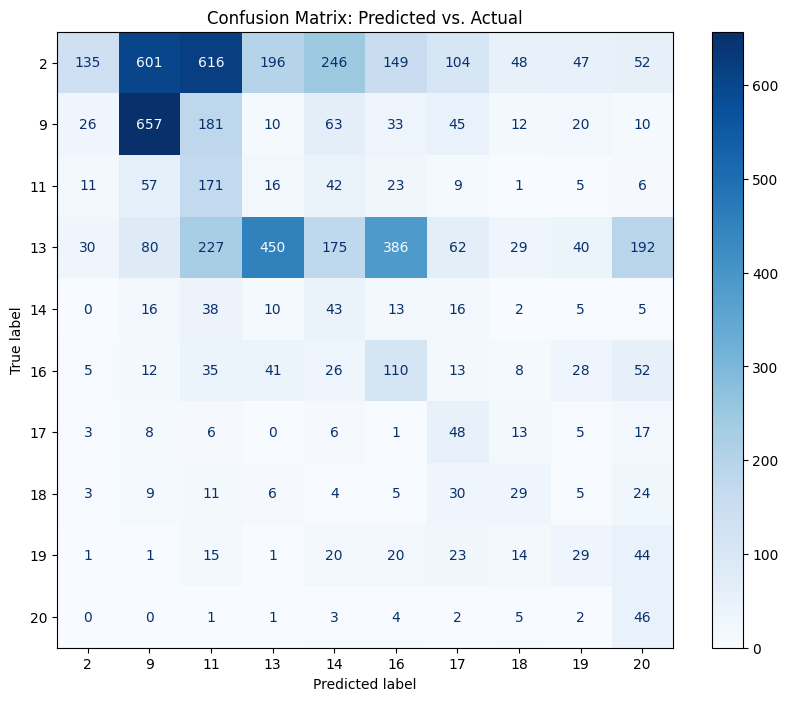

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 3. Prepare Data
print(f"\nTotal samples collected: {len(X)}")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Train SVM
print(f"Training SVM on {len(X_train)} samples...")
clf = SVC(kernel='rbf', C=10, class_weight='balanced')
clf.fit(X_train, y_train)

# 5. Evaluate with Confusion Matrix
print("\nEvaluating model...")
y_pred = clf.predict(X_test)

# Generate the numerical report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display the Matrix visually
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix: Predicted vs. Actual')
plt.show()

In [24]:
# 2. Load and Inspect Labels
gdf = gpd.read_file(SHP_PATH)

# Get unique pairs of the ID and the Text Name
# Replace 'class_id' with your actual numeric column name
label_inspection = gdf[[LABEL_COL, 'PRIMARY_FO']].drop_duplicates().sort_values(LABEL_COL)

print("--- Class ID to Habitat Name Mapping ---")
for _, row in label_inspection.iterrows():
    print(f"ID: {int(row[LABEL_COL]):<3} | Name: {row['PRIMARY_FO']}")
print("----------------------------------------\n")

--- Class ID to Habitat Name Mapping ---
ID: 2   | Name: PF1
ID: 9   | Name: FS1
ID: 10  | Name: FS1/FS2
ID: 11  | Name: FS1/PF1
ID: 12  | Name: GA1
ID: 13  | Name: GS4
ID: 14  | Name: GS4/FS1
ID: 15  | Name: GS4/FS2
ID: 16  | Name: GS4/WS1
ID: 17  | Name: WL2
ID: 18  | Name: WN6
ID: 19  | Name: WN6/FS1
ID: 20  | Name: WS1/WL2
----------------------------------------



In [27]:
print("Loading and merging Fossitt habitats...")
gdf = gpd.read_file(SHP_PATH).to_crs(meta['crs'])

# Define NAME_COL
NAME_COL = 'PRIMARY_FO'

# Map Fossitt codes into broader "Spectral Classes" to improve accuracy
fossitt_merger = {
    'GS4': 'Grassland_Wet',
    'GA1': 'Grassland_Improved',
    'GS4/WS1': 'Scrub_Woodland',
    'WN6': 'Woodland_Scrub',
    'WN6/FS1': 'Woodland_Scrub',
    'WS1/WL2': 'Woodland_Scrub',
    'WL2': 'Woodland_Scrub',
    'PF1': 'Wetland_Peatland',
    'FS1': 'Wetland_Peatland',
    'FS1/FS2': 'Wetland_Peatland',
    'FS1/PF1': 'Wetland_Peatland',
    'GS4/FS1': 'Wetland_Peatland',
    'GS4/FS2': 'Wetland_Peatland'
}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

Loading and merging Fossitt habitats...


In [28]:
print("Sampling points...")
X_list, y_list = [], []

with rasterio.open(RGB_PATH) as rgb_src, rasterio.open('ndvi_fixed.tif') as ndvi_src:
    for idx, row in gdf.iterrows():
        poly_area = row.geometry.area
        if poly_area < MIN_AREA_THRESHOLD:
            continue

        target_n = max(MIN_SAMPLES, min(int(poly_area * TARGET_DENSITY), MAX_SAMPLES))

        points_coords = []
        bounds = row.geometry.bounds
        attempts = 0

        while len(points_coords) < target_n and attempts < (target_n * 15):
            batch = max(10, target_n - len(points_coords))
            xs = np.random.uniform(bounds[0], bounds[2], batch)
            ys = np.random.uniform(bounds[1], bounds[3], batch)
            for x, y in zip(xs, ys):
                if row.geometry.contains(Point(x, y)):
                    points_coords.append((x, y))
            attempts += batch

        if not points_coords: continue

        # Batch Extraction
        rgb_samples = list(rgb_src.sample(points_coords))
        ndvi_samples = list(ndvi_src.sample(points_coords))

        for r_val, n_val in zip(rgb_samples, ndvi_samples):
            r_val, n_val = r_val.flatten(), n_val.flatten()
            if len(r_val) == 3 and not np.any(r_val == 0):
                # Feature Vector: [Red, Green, Blue, NDVI, Texture(StdDev)]
                texture = np.std(r_val)
                features = np.append(r_val, [n_val[0], texture])
                X_list.append(features)
                y_list.append(row['merged_name'])

X = np.array(X_list)
y = np.array(y_list)

print('D')

Sampling points...
D


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
print(f"Training on {len(X_train)} samples across {len(np.unique(y))} classes...")
clf = SVC(kernel='rbf', C=10, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

Training on 24815 samples across 4 classes...


SVC(C=10, class_weight='balanced')


--- FINAL CLASSIFICATION REPORT ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.54      0.43      0.48      1669
  Scrub_Woodland       0.15      0.49      0.23       330
Wetland_Peatland       0.88      0.66      0.75      3739
  Woodland_Scrub       0.33      0.71      0.45       466

        accuracy                           0.59      6204
       macro avg       0.48      0.57      0.48      6204
    weighted avg       0.71      0.59      0.63      6204



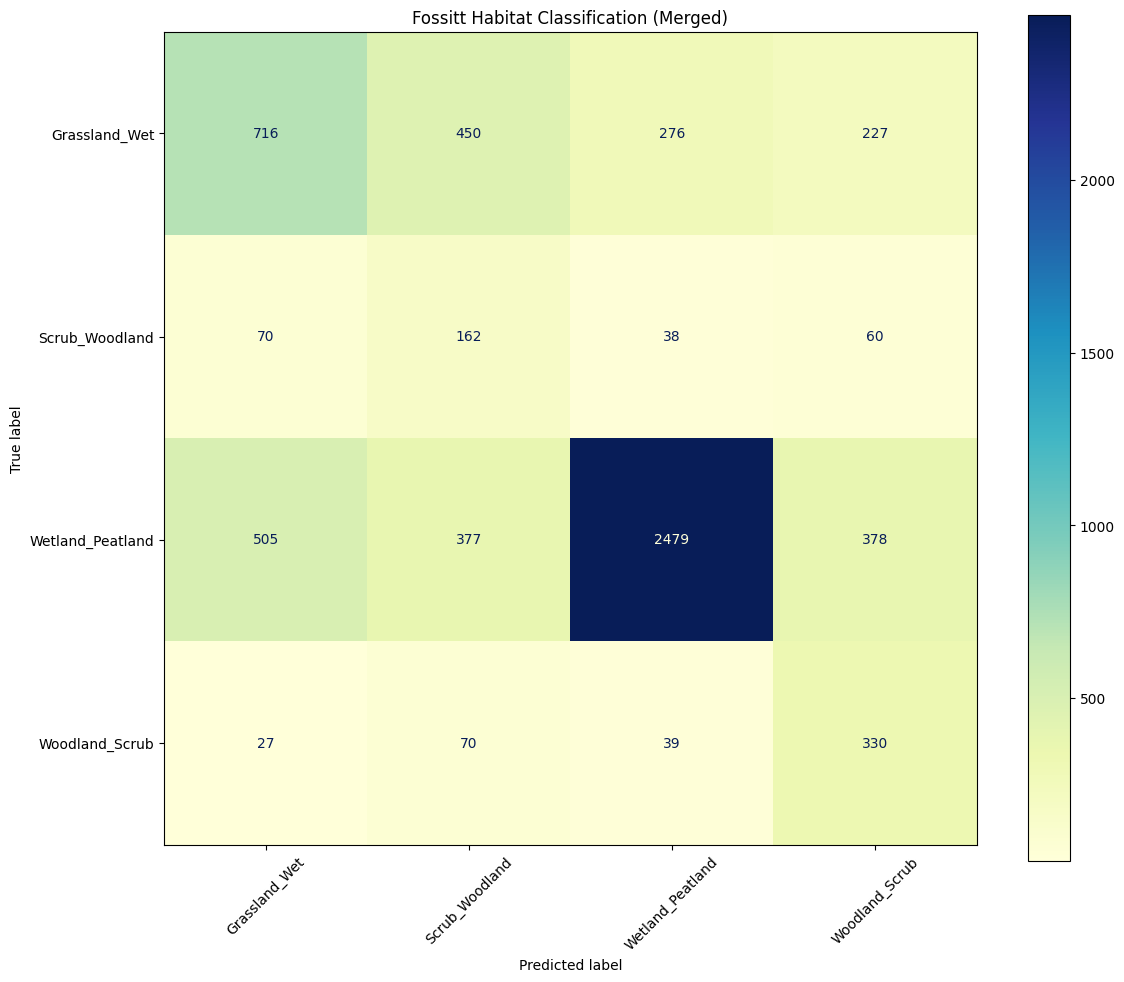

In [31]:
y_pred = clf.predict(X_test_scaled)
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    xticks_rotation=45,
    cmap='YlGnBu',
    ax=ax
)
plt.title('Fossitt Habitat Classification (Merged)')
plt.tight_layout()
plt.show()

In [33]:
y_pred = clf.predict(X_test_scaled)
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))



--- FINAL CLASSIFICATION REPORT ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.54      0.43      0.48      1669
  Scrub_Woodland       0.15      0.49      0.23       330
Wetland_Peatland       0.88      0.66      0.75      3739
  Woodland_Scrub       0.33      0.71      0.45       466

        accuracy                           0.59      6204
       macro avg       0.48      0.57      0.48      6204
    weighted avg       0.71      0.59      0.63      6204



try more merging


In [34]:
print("Merging Fossitt codes into broad spectral classes...")
gdf = gpd.read_file(SHP_PATH).to_crs(meta['crs'])

# Final Merging Dictionary: Grouping by spectral similarity
fossitt_merger = {
    # All Woody vegetation merged to one class
    'WN6': 'Woodland_Scrub', 'WL2': 'Woodland_Scrub', 'WS1/WL2': 'Woodland_Scrub',
    'WN6/FS1': 'Woodland_Scrub', 'GS4/WS1': 'Woodland_Scrub', 'Scrub_Woodland': 'Woodland_Scrub',

    # Grasslands
    'GA1': 'Grassland_Improved', 'GS4': 'Grassland_Wet',

    # Wetlands/Peatlands
    'PF1': 'Wetland_Peatland', 'FS1': 'Wetland_Peatland', 'FS1/FS2': 'Wetland_Peatland',
    'FS1/PF1': 'Wetland_Peatland', 'GS4/FS1': 'Wetland_Peatland', 'GS4/FS2': 'Wetland_Peatland'
}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

Merging Fossitt codes into broad spectral classes...


In [35]:
print("Sampling points and calculating texture...")
X_list, y_list = [], []

with rasterio.open(RGB_PATH) as rgb_src, rasterio.open('ndvi_fixed.tif') as ndvi_src:
    for idx, row in gdf.iterrows():
        poly_area = row.geometry.area
        if poly_area < MIN_AREA_THRESHOLD: continue

        target_n = max(MIN_SAMPLES, min(int(poly_area * TARGET_DENSITY), MAX_SAMPLES))

        points_coords = []
        bounds = row.geometry.bounds
        attempts = 0
        while len(points_coords) < target_n and attempts < (target_n * 15):
            batch = max(10, target_n - len(points_coords))
            xs = np.random.uniform(bounds[0], bounds[2], batch)
            ys = np.random.uniform(bounds[1], bounds[3], batch)
            for x, y in zip(xs, ys):
                if row.geometry.contains(Point(x, y)): points_coords.append((x, y))
            attempts += batch

        if not points_coords: continue

        # Batch Extraction
        rgb_gen = list(rgb_src.sample(points_coords))
        ndvi_gen = list(ndvi_src.sample(points_coords))

        for r_val, n_val in zip(rgb_gen, ndvi_gen):
            r_val, n_val = r_val.flatten(), n_val.flatten()
            if len(r_val) == 3 and not np.any(r_val == 0):
                # Feature Vector: Red, Green, Blue, NDVI, Texture (StdDev of RGB)
                texture = np.std(r_val)
                X_list.append([r_val[0], r_val[1], r_val[2], n_val[0], texture])
                y_list.append(row['merged_name'])

X = np.array(X_list)
y = np.array(y_list)

Sampling points and calculating texture...


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training SVM on {len(X_train)} samples...")
clf = SVC(kernel='rbf', C=10, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

Training SVM on 24809 samples...


SVC(C=10, class_weight='balanced')

In [37]:
y_pred = clf.predict(X_test_scaled)
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL CLASSIFICATION REPORT ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.52      0.60      0.55      1668
Wetland_Peatland       0.87      0.67      0.76      3738
  Woodland_Scrub       0.36      0.62      0.46       797

        accuracy                           0.65      6203
       macro avg       0.58      0.63      0.59      6203
    weighted avg       0.71      0.65      0.67      6203

